<h2 style="text-align:left;padding:10px;background-color:#55a166;color:#ffe;border-radius:5px;font:bold;font-size:2.25em">
Import Libraries
</h2>

In [1]:
########################### Libraries ###########################

# General
import time
from datetime import datetime
import re
import pickle
import joblib
import warnings

warnings.filterwarnings("ignore")


# Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy.stats import uniform, randint
import matplotlib.patches as mpatches
import missingno as msno

# Preprocessing
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    FunctionTransformer,
    StandardScaler,
)
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler, SMOTE,ADASYN
from sklearn.preprocessing import PowerTransformer
# Models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    ExtraTreesClassifier,
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# Metrics
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    accuracy_score,
    log_loss,
    roc_auc_score,
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
)



pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("archive.zip").drop(columns=["id"])

In [3]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
df.shape

(43400, 11)

In [5]:
df = df[df["gender"] != "Other"]

In [6]:
df.shape

(43389, 11)

In [7]:
main_df, test_df = train_test_split(df, test_size=0.2, random_state=72)

In [8]:
main_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
35546,Male,8.0,0,0,No,children,Urban,96.82,15.7,NaN,0
32938,Female,47.0,0,0,Yes,Self-employed,Urban,75.13,26.9,formerly smoked,0
32921,Male,14.0,0,0,No,children,Urban,71.39,22.4,NaN,0
27548,Female,44.0,1,0,Yes,Private,Urban,81.25,26.7,never smoked,0
23619,Male,36.0,0,0,Yes,Private,Urban,97.21,27.8,NaN,0


<h2 style="text-align:left;padding:10px;background-color:#55a166;color:#ffe;border-radius:5px;font:bold;font-size:2.25em">
Explore Data
</h2>

In [9]:
df = main_df.copy()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34711 entries, 35546 to 12762
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             34711 non-null  object 
 1   age                34711 non-null  float64
 2   hypertension       34711 non-null  int64  
 3   heart_disease      34711 non-null  int64  
 4   ever_married       34711 non-null  object 
 5   work_type          34711 non-null  object 
 6   Residence_type     34711 non-null  object 
 7   avg_glucose_level  34711 non-null  float64
 8   bmi                33563 non-null  float64
 9   smoking_status     24148 non-null  object 
 10  stroke             34711 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 3.2+ MB


In [11]:
df.isna().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1148
smoking_status       10563
stroke                   0
dtype: int64

In [12]:
df.duplicated().sum()

0

In [13]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [14]:
num_cols = ["bmi","avg_glucose_level","age"]
cat_cols = list(df.drop(columns=num_cols+["stroke"]).columns)
target_col = "stroke"

### We will use knn_imputer for dealing with nan in this column

In [15]:
knn_imputer = KNNImputer(n_neighbors=7)
df[["bmi"]] = knn_imputer.fit_transform(df[["bmi"]])

### Make custom functions for this column ⬇

In [16]:
df["smoking_status"].fillna(value="Unkown",inplace=True)

In [17]:
df["smoking_not_found"] = df["smoking_status"]=="Unkown"

In [18]:
df[num_cols].describe()

,bmi,avg_glucose_level,age
count,34711.000000,34711.000000,34711.000000
mean,28.607571,104.517934,42.261311
std,7.646498,43.155056,22.467525
min,10.300000,55.000000,0.080000
25%,23.400000,77.520000,24.000000
50%,28.100000,91.570000,44.000000
75%,32.700000,112.100000,60.000000
max,97.600000,291.050000,82.000000


In [19]:
df[cat_cols].astype("object").describe()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status
count,34711,34711,34711,34711,34711,34711,34711
unique,2,2,2,2,5,2,4
top,Female,0,0,Yes,Private,Rural,never smoked
freq,20508,31426,33063,22398,19880,17375,12886


#### Class imbalance ⬇

In [20]:
df[target_col].value_counts(normalize=True)

stroke
0    0.981476
1    0.018524
Name: proportion, dtype: float64

<h2 style="text-align:left;padding:10px;background-color:#55a166;color:#ffe;border-radius:5px;font:bold;font-size:2.25em">
EDA & Visualization
</h2>

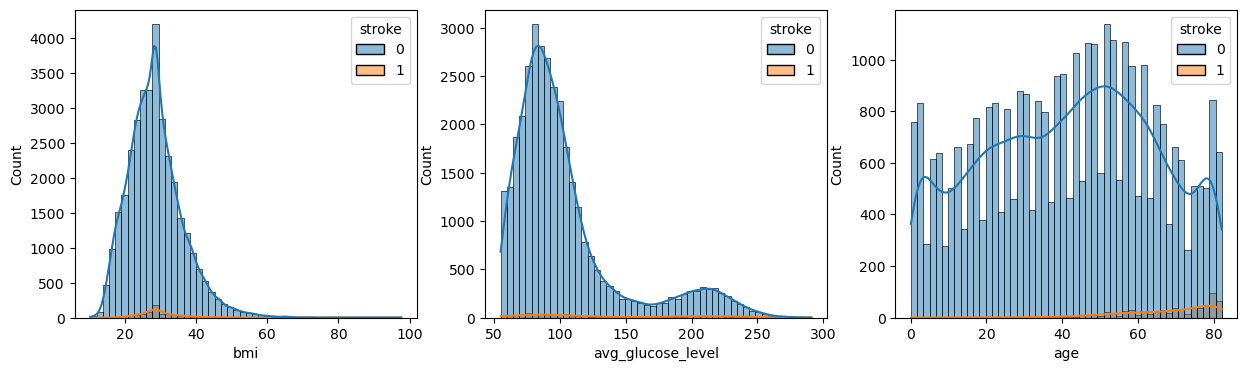

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, ax=ax[i],hue=target_col, kde=True, bins=50)
    
plt.show()

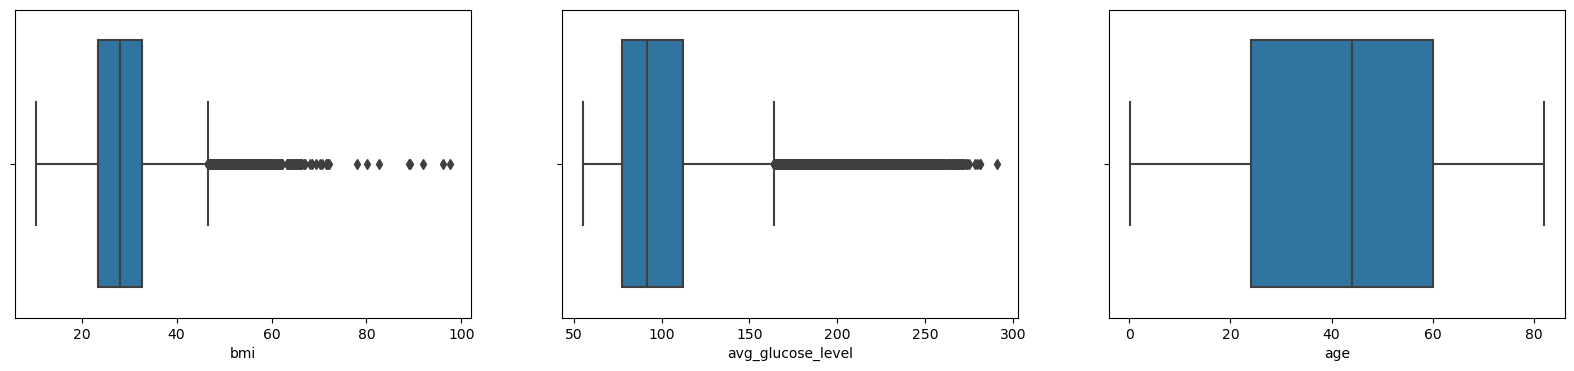

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x=col, ax=ax[i])
    
plt.show()

### Remove skewness using  `yeo-johnson` power transformation

In [23]:
power_transform = PowerTransformer()
df[num_cols] = power_transform.fit_transform(df[num_cols])

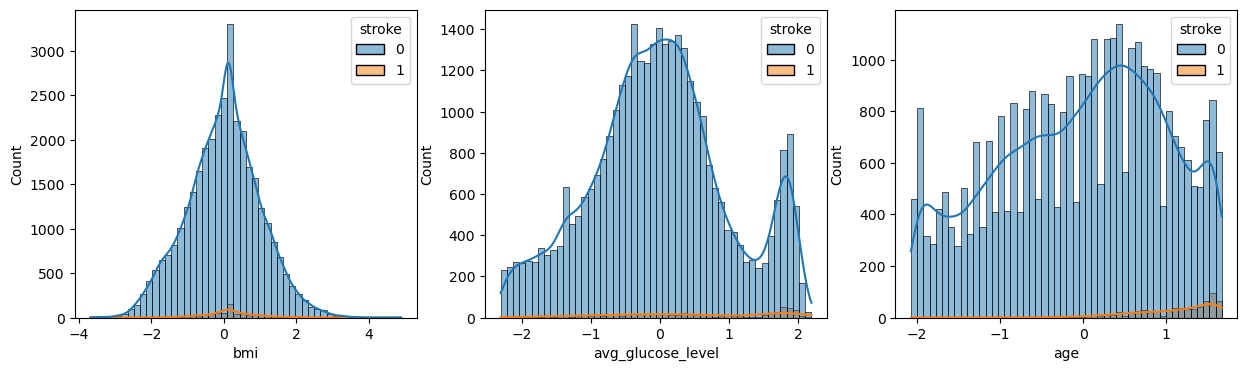

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, ax=ax[i],hue=target_col, kde=True, bins=50)
    
plt.show()

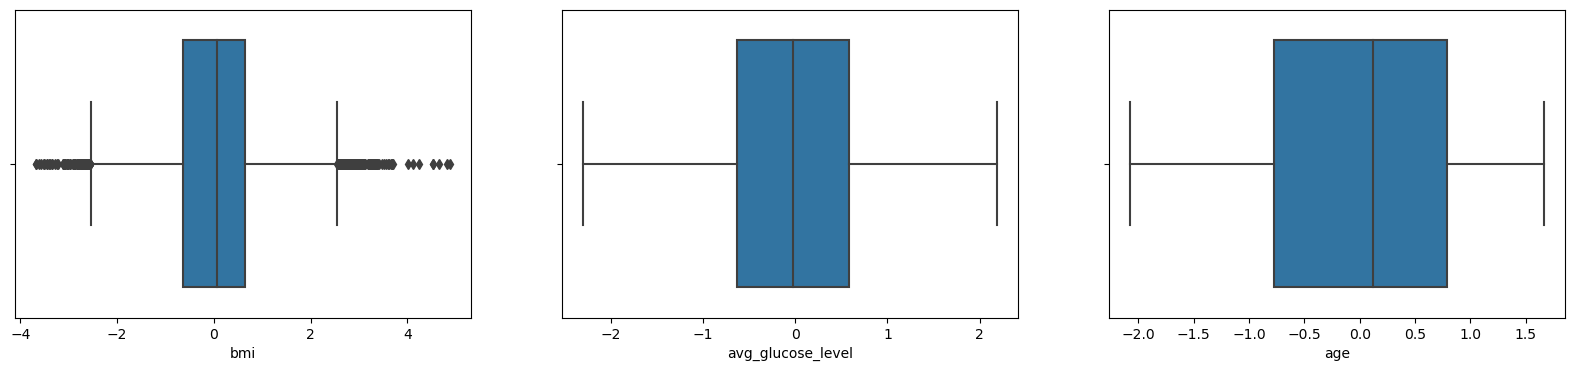

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x=col, ax=ax[i])
    
plt.show()

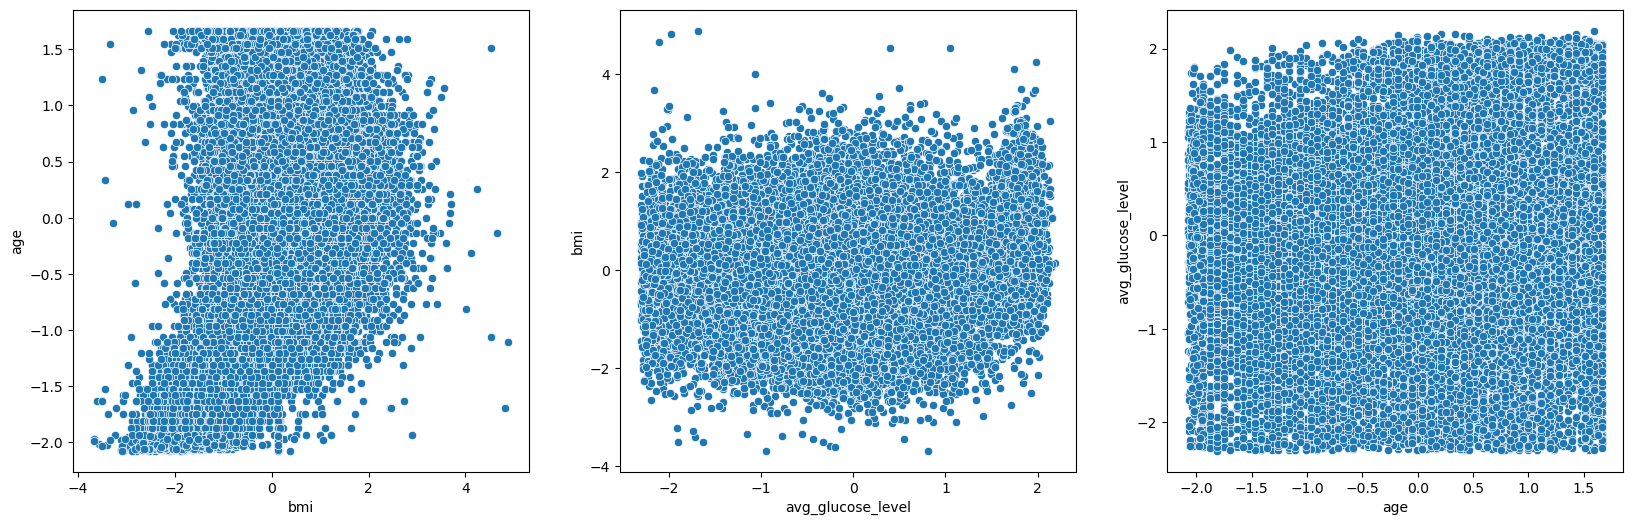

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))

for i in range(len(num_cols)):
    if i!=0:
        sns.scatterplot(data=df, x=num_cols[i],y=num_cols[i-1], ax=ax[i])
    else:
        sns.scatterplot(data=df, x=num_cols[i],y=num_cols[-1], ax=ax[i])
    
plt.show()

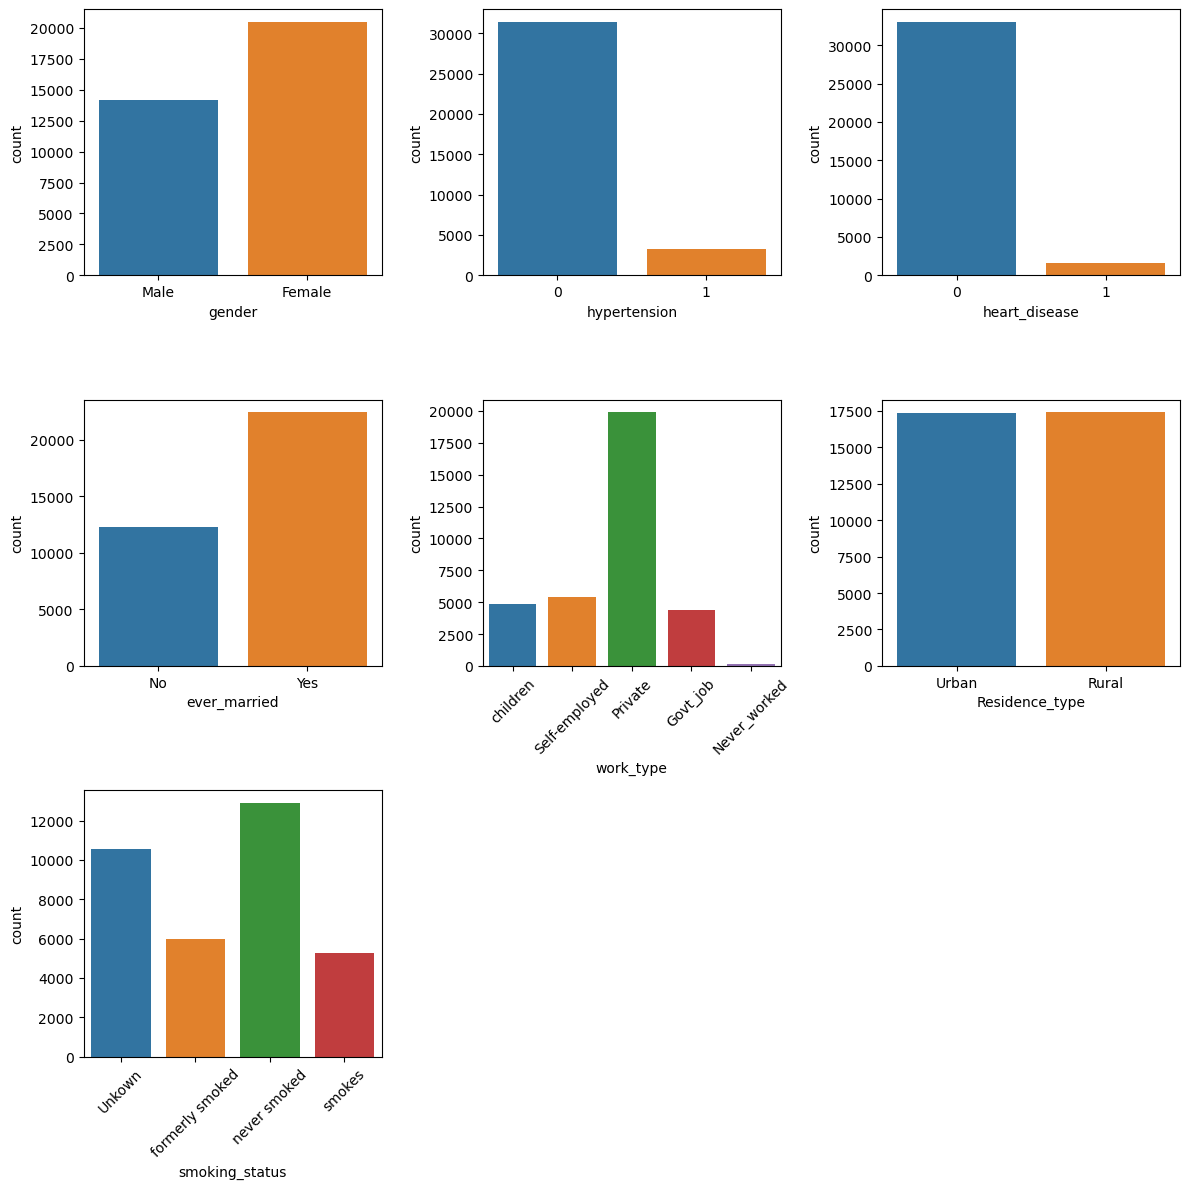

In [27]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, col in enumerate(cat_cols):
    a = i//3
    b = i%3
    sns.countplot(data=df, x=col, ax=ax[a,b])
    if df[col].nunique()>2:
        ax[a, b].set_xticklabels(ax[a, b].get_xticklabels(), rotation=45)
ax[-1, -1].remove()
ax[-1, -2].remove()
plt.tight_layout()
plt.show()

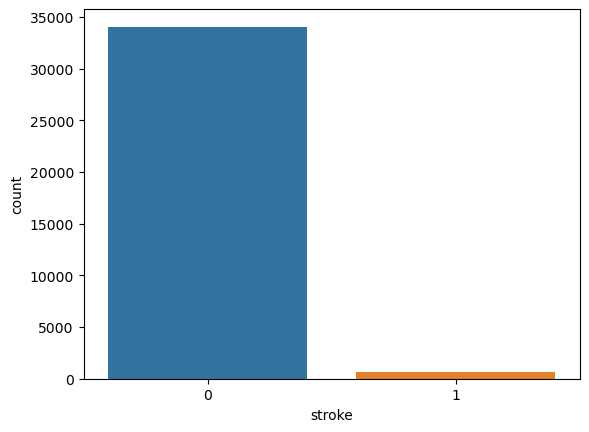

In [28]:
sns.countplot(data=df, x=target_col);

In [29]:
oe = OrdinalEncoder()
df = oe.fit_transform(df)

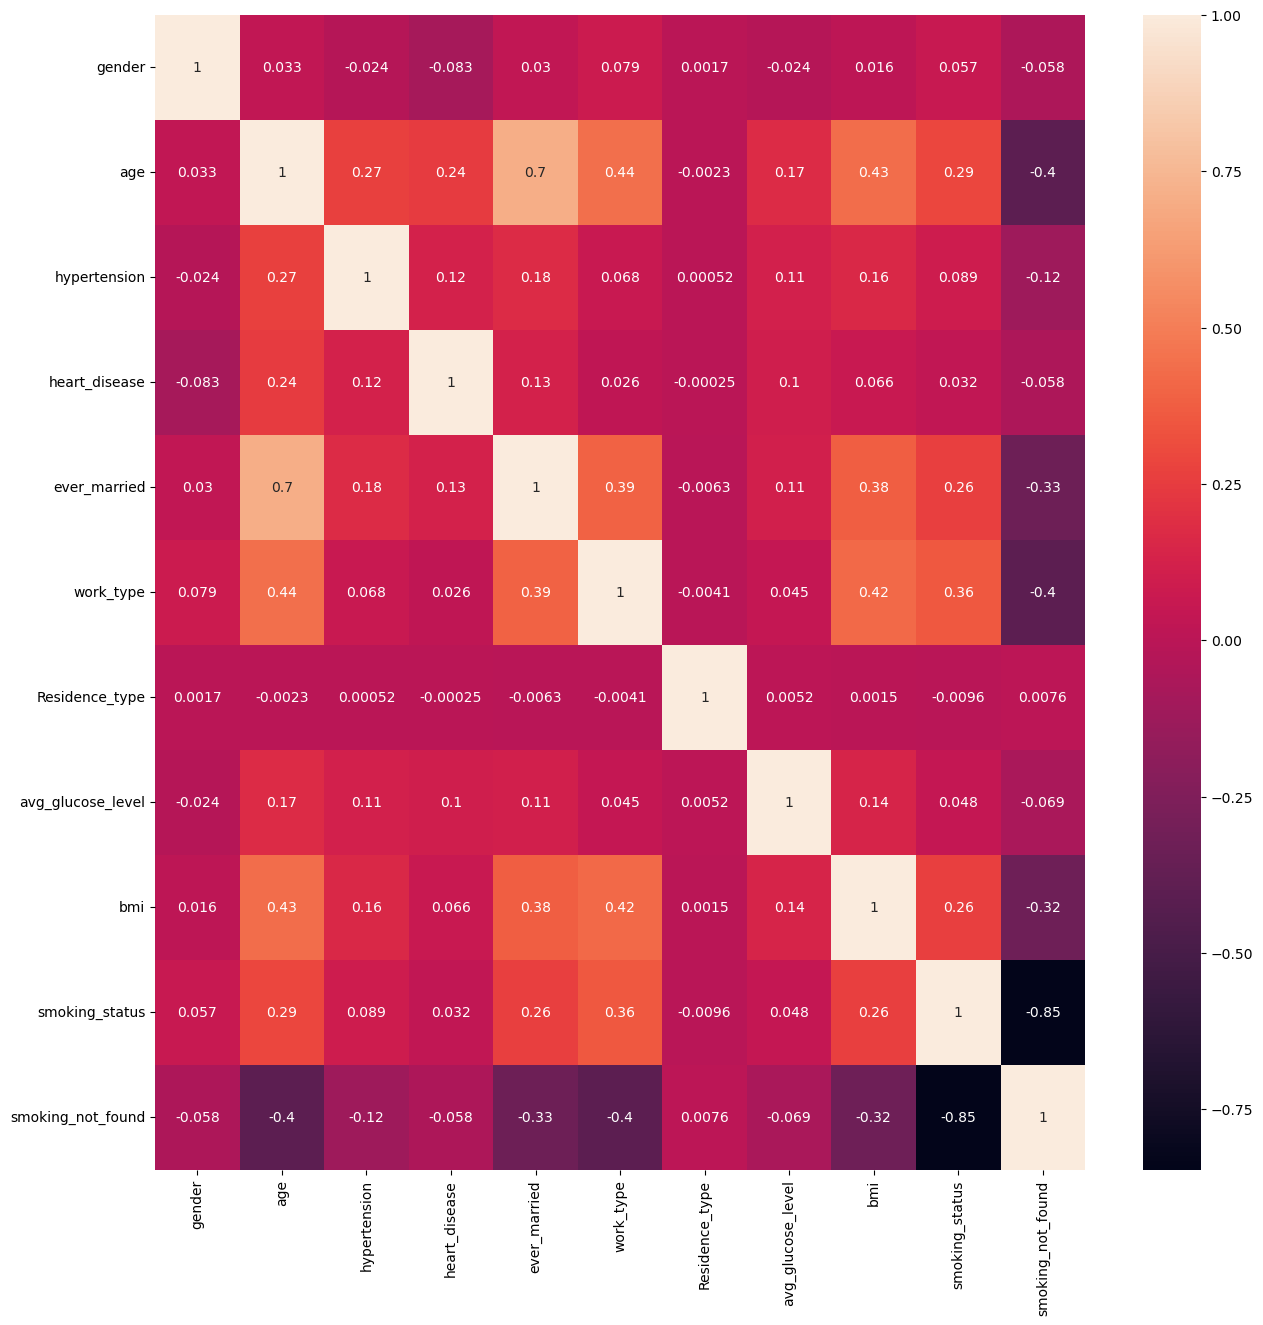

In [30]:
fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.drop(columns=["stroke"]).corr(),annot=True);

<h2 style="text-align:left;padding:10px;background-color:#55a166;color:#ffe;border-radius:5px;font:bold;font-size:2.25em">
Data Processing
</h2>

In [31]:
X = main_df.drop("stroke",axis=1) 
y = main_df["stroke"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (34711, 10)
y shape: (34711,)


In [32]:
X_train, X_val, y_train, y_val =  train_test_split(X,y, test_size= 0.2, random_state= 72)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_val.shape)
print("y_test shape:", y_val.shape)

X_train shape: (27768, 10)
y_train shape: (27768,)
X_test shape: (6943, 10)
y_test shape: (6943,)


## Pipelines

In [33]:
class HandleSmokingStatus(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["smoking_status"].fillna(value="Unknown", inplace=True)
        X_copy["smoking_not_found"] = (X_copy["smoking_status"] == "Unknown").astype(int)
        return X_copy

In [34]:
class SamplerTransformer:
    def __init__(self, sampler):
        self.sampler = sampler

    def fit(self, X):
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        return X_resampled, y_resampled

    def transform(self, X):
        return X

    def fit_transform(self, X, y):
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        return X_resampled, y_resampled

In [35]:
numerical_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=7)),
    ('power_transform', PowerTransformer(method='yeo-johnson')),
    ('standard_scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('handle_smoking_status', HandleSmokingStatus()),
    ('ordinal_encoding', OrdinalEncoder()),
    ('standard_scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],remainder='passthrough')



preprocessing_pipeline= Pipeline(steps=[
    ('preprocessor', preprocessor),
    
])
preprocessing_with_sampling = Pipeline(steps=[
    ("before_sampling",preprocessing_pipeline),
    ("sampler", SamplerTransformer(ADASYN()))
])

<h2 style="text-align:left;padding:10px;background-color:#55a166;color:#ffe;border-radius:5px;font:bold;font-size:2.25em">
Model Building
</h2>

In [36]:
X_preprocessed =preprocessing_pipeline.fit_transform(X_train)

In [37]:
X_val_processed = preprocessing_pipeline.transform(X_val)

#### Use Oversampling technique `ADASYN`


In [38]:
adasyn_sampler = ADASYN()
X_train_resampled, y_train_resampled= adasyn_sampler.fit_resample(X_preprocessed, y_train)

### Baseline

In [39]:
dummy = DummyClassifier() 

dummy.fit(X_preprocessed, y_train)

baseline_acc_score = accuracy_score(y_train, dummy.predict(X_preprocessed))
baseline_f1_score = f1_score(y_train, dummy.predict(X_preprocessed))
print(f"Baseline accuracy: {round(baseline_acc_score,2)}")
print(f"Baseline f1-score: {round(baseline_f1_score,2)}")

Baseline accuracy: 0.98
Baseline f1-score: 0.0


## Model Selection

In [40]:
models = [
    LogisticRegression(random_state = ord("H")),
    DecisionTreeClassifier(random_state = ord("H")),
    RandomForestClassifier(random_state = ord("H")),
    GradientBoostingClassifier(random_state =ord("H")),
    XGBClassifier(random_state=ord("H")),
    ExtraTreesClassifier(random_state=ord("H")),
    BaggingClassifier(random_state=ord("H")),
    AdaBoostClassifier(random_state=ord("H")),
]

In [41]:
models_df = pd.DataFrame(columns=["time_for_training", "training_accuracy", "val_accuracy","recall_train","recall_val"])

In [42]:
# iterate over models, train them, append results
for model in models:
    # start timer
    start = time.time()
    # Train the model
    clf = model.fit(X_preprocessed, y_train) # I didn't make a pipeline of the model as a whole yet to save time
    # end timer
    end = time.time()
    # estimated time
    estimated_time = round(end-start,2)
    # evaluate model
    train_acc = accuracy_score(y_train, clf.predict(X_preprocessed))
    val_acc = accuracy_score(y_val, clf.predict(X_val_processed))
    train_recall = recall_score(y_train, clf.predict(X_preprocessed))
    val_recall = recall_score(y_val, clf.predict(X_val_processed))
    models_df.loc[model.__class__.__name__] = [estimated_time, train_acc, val_acc,train_recall,val_recall]

In [43]:
models_df.sort_values(by="recall_val",ascending=False)

,time_for_training,training_accuracy,val_accuracy,recall_train,recall_val
DecisionTreeClassifier,0.08,1.000000,0.959384,1.000000,0.076389
BaggingClassifier,0.71,0.995823,0.978251,0.767535,0.006944
LogisticRegression,0.05,0.982030,0.979260,0.000000,0.000000
RandomForestClassifier,2.42,1.000000,0.979116,1.000000,0.000000
GradientBoostingClassifier,2.76,0.982714,0.978540,0.038076,0.000000
XGBClassifier,0.97,0.985703,0.978828,0.204409,0.000000
ExtraTreesClassifier,1.51,1.000000,0.977387,1.000000,0.000000
AdaBoostClassifier,1.02,0.982030,0.979260,0.000000,0.000000


What if we used oversampling

In [44]:
models_df_over_sampling = pd.DataFrame(
    columns=["time_for_training", "training_accuracy", "val_accuracy","recall_train","recall_val"]
)

In [45]:
# iterate over models, train them, append results
for model in models:
    # start timer
    start = time.time()
    # Train the model
    clf = model.fit(X_train_resampled, y_train_resampled) # I didn't make a pipeline of the model as a whole yet to save time
    # end timer
    end = time.time()
    # estimated time
    estimated_time = round(end-start,2)
    # evaluate model
    train_acc = accuracy_score(y_train_resampled, clf.predict(X_train_resampled))
    val_acc = accuracy_score(y_val, clf.predict(X_val_processed))
    train_recall = recall_score(y_train_resampled, clf.predict(X_train_resampled))
    val_recall = recall_score(y_val, clf.predict(X_val_processed))
    models_df_over_sampling.loc[model.__class__.__name__] = [estimated_time, train_acc, val_acc,train_recall,val_recall]

In [46]:
models_df_over_sampling.sort_values(by="recall_val",ascending=False)

,time_for_training,training_accuracy,val_accuracy,recall_train,recall_val
LogisticRegression,0.06,0.796095,0.736857,0.849474,0.763889
AdaBoostClassifier,2.40,0.844969,0.798646,0.884171,0.659722
GradientBoostingClassifier,10.24,0.893640,0.873398,0.903341,0.409722
DecisionTreeClassifier,0.29,1.000000,0.936771,1.000000,0.083333
ExtraTreesClassifier,3.73,1.000000,0.950022,1.000000,0.069444
XGBClassifier,0.32,0.977170,0.961544,0.962028,0.034722
BaggingClassifier,2.21,0.998825,0.961400,0.997792,0.027778
RandomForestClassifier,9.70,1.000000,0.955495,1.000000,0.020833


<h2 style="text-align:left;padding:10px;background-color:#55a166;color:#ffe;border-radius:5px;font:bold;font-size:2.25em">
Fine Tuning
</h2>

We will continue with `GradientBoostingClassifier` & `Logistic Regression` with Sampling

In [47]:
X_processed, y_processed = preprocessing_with_sampling.fit_transform(X,y)
X_processed.shape,y_processed.shape

((68360, 11), (68360,))

In [72]:
joblib.dump(preprocessing_with_sampling, "preprocessing_with_sampling.pkl")

['preprocessing_with_sampling.pkl']

In [48]:
model_gboost = GradientBoostingClassifier(random_state=ord("H"))
model_lr = LogisticRegression(random_state=ord("H"))

In [49]:
log_reg_param_grid = {'C': uniform(loc=0, scale=4)}
gb_param_grid = {'learning_rate': uniform(loc=0.01, scale=0.1),
                 'n_estimators': randint(50, 200),
                 'max_depth': randint(3, 10)}

In [50]:
scorer = {
    "recall":make_scorer(recall_score),
    "accuracy":make_scorer(accuracy_score)
}

In [51]:
gbc_random_search = RandomizedSearchCV(
    estimator=model_gboost,
    param_distributions=gb_param_grid,
    n_iter=30,  
    cv=5,        
    scoring=scorer,
    n_jobs=-1, 
    verbose = 2,
    refit="recall"
)

lr_random_search = RandomizedSearchCV(
    estimator=model_lr,
    param_distributions=log_reg_param_grid,
    n_iter=100, 
    cv=5,      
    scoring=scorer,
    n_jobs=-1,
    verbose=2,
    refit="recall"
)

In [52]:
lr_random_search.fit(X_processed, y_processed)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=72),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000298CD57A3D0>},
                   refit='recall',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'recall': make_scorer(recall_score)},
                   verbose=2)

In [53]:
print("Logistic Regression Best f1 Score:", lr_random_search.best_score_)

Logistic Regression Best f1 Score: 0.8285338585483346


In [54]:
accuracy_score(lr_random_search.best_estimator_.predict(X_processed),y_processed)

0.7830748976009362

In [55]:
 lr_random_search.best_params_

{'C': 0.05433755828606346}

In [56]:
best_model_lr = lr_random_search.best_estimator_

In [57]:
model_file = "logistic_regression_model4.pkl"
joblib.dump(best_model_lr, model_file)

['logistic_regression_model4.pkl']

In [58]:
gbc_random_search.fit(X_processed, y_processed)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=72),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000298CD579D50>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000298CD532B50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000298CD2144D0>},
                   refit='recall',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'recall': make_scorer(recall_score)},
                   verbose=2)

In [59]:
print("Gradient Boosting Classifier Best recall Score:", gbc_random_search.best_score_)

Gradient Boosting Classifier Best recall Score: 0.9677181638682878


In [60]:
pd.DataFrame(gbc_random_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,38.757560,0.733916,0.067042,0.000642,0.100986,7,93,"{'learning_rate': 0.10098570655268373, 'max_depth': 7, 'n_estimators': 93}",0.875474,0.973462,0.969816,0.962677,0.957866,0.947859,0.036598,13,0.933002,0.969646,0.974912,0.969573,0.965916,0.962610,0.015079,7
1,49.577898,3.590232,0.094397,0.020487,0.034735,5,154,"{'learning_rate': 0.034734819318778705, 'max_depth': 5, 'n_estimators': 154}",0.899971,0.932925,0.951589,0.918355,0.896195,0.919807,0.020666,20,0.896650,0.910620,0.922542,0.897089,0.886849,0.902750,0.012456,20
2,74.493156,0.494279,0.117443,0.005339,0.037577,8,135,"{'learning_rate': 0.037577052733573875, 'max_depth': 8, 'n_estimators': 135}",0.912657,0.976378,0.980023,0.974923,0.959469,0.960690,0.025025,6,0.931173,0.959333,0.962551,0.956407,0.949093,0.951712,0.011192,12
3,76.951985,3.132466,0.107203,0.003061,0.059794,6,197,"{'learning_rate': 0.0597939808242944, 'max_depth': 6, 'n_estimators': 197}",0.870516,0.963838,0.967483,0.953783,0.951742,0.941473,0.035968,16,0.929564,0.974839,0.972060,0.959040,0.967525,0.960606,0.016418,9
4,48.860106,1.538684,0.083399,0.007916,0.021169,5,154,"{'learning_rate': 0.021168622825022104, 'max_depth': 5, 'n_estimators': 154}",0.907262,0.931175,0.952610,0.914711,0.877679,0.916687,0.024959,22,0.881802,0.888019,0.902355,0.873757,0.858177,0.880822,0.014691,24


In [61]:
accuracy_score(gbc_random_search.best_estimator_.predict(X_processed),y_processed)

0.958908718548859

In [62]:
 gbc_random_search.best_params_

{'learning_rate': 0.022953765797278064, 'max_depth': 9, 'n_estimators': 165}

In [63]:
best_model_grad_boost = gbc_random_search.best_estimator_

In [64]:
model_file = "GradBoost_best_model2.pkl"
joblib.dump(best_model_grad_boost, model_file)

['GradBoost_best_model2.pkl']

<h2 style="text-align:left;padding:10px;background-color:#55a166;color:#ffe;border-radius:5px;font:bold;font-size:2.25em">
Evaluation & Communication of Results
</h2>

In [65]:
r_model = joblib.load("logistic_regression_model4.pkl")

In [66]:
b_model = joblib.load("GradBoost_best_model2.pkl")

In [67]:
X_test = test_df.drop(columns=["stroke"])
y_test =test_df["stroke"]
y_test_processed = y_test.copy()
X_test_processed = preprocessing_with_sampling.transform(X_test)

In [68]:
rtest_acc = accuracy_score(r_model.predict(X_test_processed), y_test_processed)
btest_acc = accuracy_score(b_model.predict(X_test_processed), y_test_processed)
rtest_acc,btest_acc

(0.7330029960820466, 0.9105784743028348)

In [69]:
rtest_recall = recall_score(r_model.predict(X_test_processed), y_test_processed)
btest_recall= recall_score(b_model.predict(X_test_processed), y_test_processed)
rtest_recall,btest_recall

(0.04927536231884058, 0.0667574931880109)

In [70]:
print( classification_report(b_model.predict(X_test_processed),y_test_processed) )

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7944
           1       0.35      0.07      0.11       734

    accuracy                           0.91      8678
   macro avg       0.63      0.53      0.53      8678
weighted avg       0.87      0.91      0.88      8678



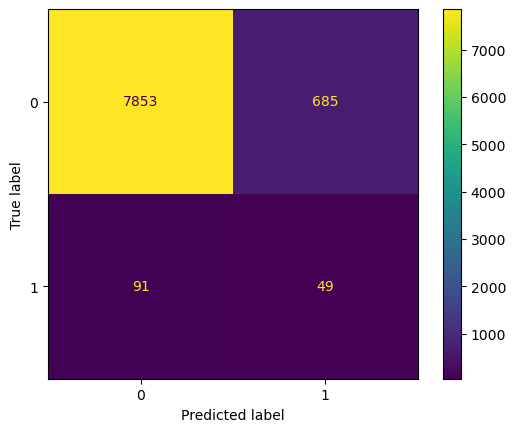

In [71]:
ConfusionMatrixDisplay.from_estimator(b_model,X_test_processed,y_test_processed);